In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using RandomizedLinAlg
using RData  # Load the RData package
using RCall

In [2]:
include("../../utils/util2.j")

generate_comparison_table (generic function with 2 methods)

In [3]:
@load "../data/sim1.jld";

In [4]:
## Precalculation I ##
# Construct maximin ordering
# Convert Julia matrix to R
@rput coords
# Use order_maxmin_exact from GPvecchia
R"""
library(GPvecchia) # i had to install this package i added this 
# Apply maxmin ordering using the built-in function
ordered_indices <- order_maxmin_exact(coords)
"""
# Get results back to Julia
@rget ordered_indices;

In [5]:
# reorder data #
Y_ord = Y[ordered_indices, :];
X_ord = X[ordered_indices, :];
coords_ord = coords[ordered_indices, :];
F_ord = F0[ordered_indices, :]; # not needed here, used in model comparison step

In [6]:
# build nearest neighbor, might take some time 
m = 15
K = 2 # No. factors
NN = BuildNN(coords_ord, m);

In [7]:
## Precalculation II ##
# priors #
K = 2;
μβ = fill(0.0, p, q); inv_Vr = zeros(Float64, p, p); #inv_Vr[1, 1] = 1;
μΛ = fill(0.0, K, q); inv_VΛ = zeros(Float64, K, K);
aΣ = 2; bΣ = fill(1, q); # later will want to add something to estimate sigma//initial starting point, here we jsut assumed something 
inv_Lr = sparse(1:p, 1:p, fill(0.1, p));
inv_LΛ = sparse(1:K, 1:K, fill(0.1, K));
ϕ_sam = [4.0, 6.0]; #[6.0, 9.0] #practical range from 3000 to 150

# A and D #
nIndx = length(NN.nnIndx)
A = [Array{Float64}(undef, nIndx) for i in 1:K]
D = [Array{Float64}(undef, n) for i in 1:K]
I_A = [spzeros(n, n) for i in 1:K] # 1-A
A_new = [Array{Float64}(undef, nIndx) for i in 1:K]
D_new = [Array{Float64}(undef, n) for i in 1:K]
I_A_new = [spzeros(n, n) for i in 1:K]
    
nnIndx_col = vcat(NN.nnIndx, 1:n) # Index of columns (for getting the original nxn matrix back; we stored it us spzeros so it takes less space)
nnIndx_row = zeros(Int64, 0) # Index of rows initialization
for i in 2:m
    nnIndx_row = vcat(nnIndx_row, fill(i, i-1))
end
nnIndx_row = vcat(nnIndx_row, repeat((m + 1):n, inner = m), 1:n)
dim_invD = n*q;

In [8]:
## Pre-allocation ##
# Pre-allocation for MCMC samples
N_sam = 20000;

# Pre-allocation for F updates
nsam = (n * q) + (K * n);
Xtilde = spzeros(Float64, (q+K)*n, n*K);
Ytilde = Array{Float64}(undef, nsam);
F_sam = Array{Float64, 2}(undef, n, K);
Fqr = qr(zeros(Float64, n, K)) 
inv_sqrt_Σ_diag = Vector{Float64}(undef, q)
invD_ele = Vector{Float64}(undef, n*q)
invD = spzeros(Float64, n*q, n*q)
invΣhalf = spzeros(Float64, q, q)
F_m = zeros(Float64, 1, K);
v = Array{Float64}(undef, nsam); # storage samples from standard normal

# Pre-allocation for γ, Σ updates
Ystar = vcat(Y_ord, inv_Lr * μβ, fill(0.0, K, q)); # (NTotal+p+K) by q matrix
Xstar = vcat(hcat(X_ord, F_sam), hcat(inv_Lr, spzeros(p, K)), hcat(spzeros(K, p), sparse(1:K, 1:K, 1.0)));
μγstar = vcat(μβ, μΛ); #invVγstar = fill(0.0, p + K, p + K);
invVγstar = cholesky(sparse(I, p+K, p+K)); # doesn't fine in-place update for this 
u = Array{Float64}(undef, (p + K) * q);  # Pre-allocate space for random samples;
Y_Xm = spzeros(n + p + K, q); # store the residual
bstar = fill(0.0, q); astar = aΣ + 0.5 * (n);

In [9]:
## Initalization (some are optional) ##
β0 = (X_ord'X_ord)\(X_ord'Y_ord);
Residuals = Y_ord - X_ord*β0;
#γ_sam = vcat((X'X)\(X'Y), fill(0.0, K, q));
reordered_result = reorder_svd_by_spatial_range(Residuals, coords_ord, K, 1000, 11)
γ_sam = vcat((X_ord'X_ord)\(X_ord'Y_ord), reordered_result);
Σ_sam = [var(Residuals[:, j]) for j in 1:size(Residuals, 2)];

# force the initial column of F to start from the noisy factor 
#γ_sam = vcat((X'X)\(X'Y), Λ[[2, 1], :]);
#Σ_sam = [0.5, 1, 0.4, 2, 0.3, 2.5, 3.5, 0.45, 1.5, 0.5]; #fill(1.0, q);

Spatial ranges in descending order:
PC1: 0.3026341736784993
PC2: 0.22733007351137913


In [10]:
using DelimitedFiles
writedlm("../results/PMCMC/γ_sam.csv", fill(0.0, 1, q), ", ");
writedlm("../results/PMCMC/Σ_sam.csv", 0.0, ", ");
writedlm("../results/PMCMC/F_sam.csv", fill(0.0, 1, K), ", ");

In [11]:
# for loop for MCMC chain #
Random.seed!(11);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    # Build the matrix D_Sigma_o^{1/2} #
    # Compute inverse square root in-place
    @. inv_sqrt_Σ_diag = 1 / sqrt(Σ_sam)
    # Efficient broadcasting for invD_ele
    invD_ele .= repeat(inv_sqrt_Σ_diag, inner=n)
    # Update sparse matrices
    invD = sparse(1:(n*q), 1:(n*q), invD_ele)
    invΣhalf = sparse(1:q, 1:q, 1 ./ sqrt.(Σ_sam))
    
    if l == 1
        for k in 1:K
            getAD(coords_ord, NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[k, l], 0.5, A[k], D[k]);
            I_A[k] = sparse(nnIndx_row, nnIndx_col, vcat(-A[k], ones(n)));
        end
    end
    Ytilde .= vcat(invD * vec(Y_ord - X_ord * γ_sam[1:p, :]), zeros(K * n));
    Xtilde .= vcat(kron(invΣhalf * sparse(transpose(γ_sam[(p + 1):(p + K), :])), 
                            sparse(1:n, 1:n, ones(n))),
             blockdiag([Diagonal(1 ./ sqrt.(D[k])) * I_A[k] for k in 1:K]...));
       
    # use LSMR to generate sample of F # 
    randn!(v)  # Fills v with standard normal samples
    elapsed_time = @elapsed begin
    F_sam .= reshape(lsmr(Xtilde, collect(Ytilde) + v), :, K);
    end
    
    # Print the elapsed time
    #println("Iteration $l: Time taken for lsmr step = $elapsed_time seconds")
    
    F_m .= mean(F_sam, dims = 1);
    F_sam .-= F_m;

    # Perform thin QR on the tall slice of F_sam in-place
    Fqr = qr!(F_sam)  # Note the ! for in-place modification

    # Assign scaled Q to F_samples
    F_sam .= Matrix(Fqr.Q)
    rmul!(F_sam, sqrt(n-1))   # scale in-place
    
    io1 = open("../results/PMCMC/F_sam.csv", "a" );
    writedlm(io1, F_sam, ", ");
    close(io1);

    # Sample Σ and γ#
    Xstar[1:n, (p+1):(p+K)] .= F_sam; # update Xstar with F_sam
    
    # use MNIW to sample γ Σ #
    invVγstar = cholesky(Xstar'Xstar);
    #mul!(μγstar, transpose(Xstar), Ystar); μγstar = invVγstar \ μγstar;
    μγstar .= invVγstar \ (Xstar'Ystar);
    Y_Xm .= Ystar - Xstar * μγstar;      
    bstar .= [bΣ[ind] + 0.5 * (norm(Y_Xm[:, ind])^2) for ind in 1:q];
    Σ_sam .= [rand(InverseGamma(astar, bstar[ind]), 1)[1] for ind in 1:q];          # sample Σ
    randn!(u)  # Fills u with standard normal samples
    γ_sam .= (invVγstar.U \ reshape(u, (p + K), q)) * 
                    Diagonal(sqrt.(Σ_sam)) + μγstar;          # sample γ    

    
    io2 = open("../results/PMCMC/Σ_sam.csv", "a" );
    writedlm(io2, Σ_sam, ", ");
    close(io2);
    io3 = open("../results/PMCMC/γ_sam.csv", "a" );
    writedlm(io3, γ_sam, ", ");
    close(io3)
    
    next!(prog) # monitor the progress
end

Computing initial pass... 100%|██████████████████████████████████████████████████| Time: 0:06:14


In [12]:
#load data
using CSV
using DataFrames
using StatsBase

γ_sam = Matrix{Float64}(CSV.read("../results/PMCMC/γ_sam.csv", DataFrame));
ind_γ_sam = (1): (p + K) :((p + K) * N_sam);
Σ_sam = Matrix{Float64}(CSV.read("../results/PMCMC/Σ_sam.csv", DataFrame));
ind_Σ_sam = (1): q :(q * N_sam);

In [13]:
F_sam = Matrix{Float64}(CSV.read("../results/PMCMC/F_sam.csv", DataFrame));
ind_F_sam = (1): n :(n * N_sam);

In [14]:
N_warmup = Integer(trunc(0.25 * N_sam));

In [15]:
# post-processing #
# step 1 compute the posterior mean
Λ_mean = Array{Float64, 2}(undef, K, q);
for k in 1:K
    Λ_mean[k, :] = mean(γ_sam[((k + p)+ N_warmup*(p+K)):(p+K):(k+p+(p+K)*(N_sam-1)), :], dims = 1);
end
Λ_mean

# step 2 label switching
labels = zeros(Int, N_sam, K);

# For each iteration and each k
for i in 1:N_sam
    for k in 1:K
        # Extract current row sample and corresponding mean row
        row_sample = γ_sam[((k + p)+ (i-1)*(p+K)), :];
        row_mean = Λ_mean[k,:];
        
        # Compute inner product and determine sign
        inner_prod = dot(row_sample, row_mean)
        labels[i,k] = sign(inner_prod)
        
        # Switch the sign when the inner product is negative
        if labels[i,k] == -1 
            γ_sam[((k + p)+ (i-1)*(p+K)), :] = -γ_sam[((k + p)+ (i-1)*(p+K)), :];
            F_sam[(1+(i-1)*n):((i)*n), k] = -F_sam[(1+(i-1)*n):((i)*n), k]; # flip sign for iteration i for F
        end
    end
end
[countmap(labels[(N_warmup+1):N_sam, col]) for col in 1:K]

2-element Vector{Dict{Int64, Int64}}:
 Dict(1 => 15000)
 Dict(-1 => 5756, 1 => 9244)

In [16]:
#=
# post-processing for F #
# step 1 compute the posterior mean
F_mean = [mean(F_sam[(i .+ (n*(N_warmup+1)):n:(n*N_sam)), j]) 
    for i in 1:n, j in 1:K];

# step 2 label switching
labels_F = zeros(Int, N_sam, K);

# For each iteration and each k
for i in 1:N_sam
    for k in 1:K
        # Extract current row sample and corresponding mean row
        f_sample = F_sam[(1+(i-1)*n):((i)*n), k];
        f_mean = F_mean[:, k];
        
        # Compute inner product and determine sign
        inner_prod = dot(f_sample, f_mean)
        labels_F[i,k] = sign(inner_prod)
        
        # Switch the sign when the inner product is negative
        if labels_F[i,k] == -1 
            F_sam[(1+(i-1)*n):((i)*n), k] = -F_sam[(1+(i-1)*n):((i)*n), k]; 
        end
    end
end
[countmap(labels_F[(N_warmup+1):N_sam, col]) for col in 1:K]
=#

In [17]:
#[countmap((labels_F - labels)[:, col]) for col in 1:K]

# MCMC Chain check

In [18]:
# packages for diagnostic test
using StatsPlots
using MCMCChains
using PrettyTables
using MCMCDiagnosticTools

In [19]:
β_pos_sam = Array{Float64, 3}(undef, N_sam , p * q, 1);
β_pos_sam[:, :, 1] = hcat([γ_sam[ind_γ_sam .+ (i - 1), j] for i in 1:p, j in 1:q]...);
β0_chain = Chains(β_pos_sam[(N_warmup+1):N_sam, 1:2:(q*p), :]);
#pβ0 = plot(β0_chain) # check as needed

In [20]:
# For β1 (remaining coefficients) - taking all columns except the intercepts
remaining_cols = setdiff(1:(p*q), 1:p:(q*p))  # Get all column indices except intercepts
β1_chain = Chains(β_pos_sam[(N_warmup+1):N_sam, remaining_cols, :]);

In [21]:
Λ_pos_sam = Array{Float64, 3}(undef, N_sam, K * q, 1);
Λ_pos_sam[:, :, 1] = hcat([γ_sam[ind_γ_sam .+ (p + i - 1), j] for i in 1:K, j in 1:q]...)
Λ_chain = Chains(Λ_pos_sam[(N_warmup+1):N_sam, :, :]);#[:, [2, 8, 10, 12, 13, 15, 19, 22, 29, 33, 38, 41, 43], :]); #N_warmup
#pΛ = plot(Λ_chain) # check as needed

In [22]:
F_pos_sam = Array{Float64, 3}(undef, N_sam, K*n, 1);
F_pos_sam[:, :, 1] = hcat([F_sam[ind_F_sam .+ (i - 1), j] for i in 1:n, j in 1:K]...)
F_chain = Chains(F_pos_sam[(N_warmup+1):N_sam, :, :]);#[:, [2, 8, 10, 12, 13, 15, 19, 22, 29, 33, 38, 41, 43], :]);
#pF = plot(F_chain) 

In [23]:
#F_chain = Chains(F_pos_sam[(N_warmup+1):N_sam, [100, 208, 310, 412, 513, 601, 702, 1300, 1400, 1033, 1380, 1410, 1830], :]);#[:, [2, 8, 10, 12, 13, 15, 19, 22, 29, 33, 38, 41, 43], :]);
#pF = plot(F_chain) # check as needed

In [24]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam, q, 1);
Σ_pos_sam[:, :, 1] = hcat([Σ_sam[ind_Σ_sam .+ (ind - 1)] for ind in 1:q]...);
Σ_chain = Chains(Σ_pos_sam[(N_warmup+1):N_sam, :, :]);
#pΣ = plot(Σ_chain) # check as needed

In [25]:
#mean(Σ_pos_sam[(N_warmup+1):N_sam, :, :], dims = 1)[:]  #[0.5, 1, 0.4, 2, 0.3, 2.5, 3.5, 0.45, 1.5, 0.5]

In [26]:
#sum(mean(Σ_pos_sam[(N_warmup+1):N_sam, :, :], dims = 1))

In [27]:
#sum(std(Y, dims = 1).^2)

In [28]:
# generate table of ESS
using DataFrames
using Statistics

function generate_ess_summary(β0_chain, β1_chain, Λ_chain, F_chain, Σ_chain; digits::Int = 0)
    # Compute ESS for each parameter group
    β0_ess = ess(β0_chain)
    β1_ess = ess(β1_chain)
    Λ_ess = ess(Λ_chain)
    F_ess = ess(F_chain)
    Σ_ess = ess(Σ_chain)

    # Create a DataFrame to store results
    ess_summary = DataFrame(
        Parameter = ["β0", "β1", "Λ", "F", "Σ"],
        Minimum_ESS = round.(
            [minimum(β0_ess[:, 2]), minimum(β1_ess[:, 2]), minimum(Λ_ess[:, 2]), minimum(F_ess[:, 2]),
                minimum(Σ_ess[:, 2])], 
            digits = digits
        ),
        Mean_ESS = round.(
            [mean(β0_ess[:, 2]), mean(β1_ess[:, 2]), mean(Λ_ess[:, 2]), mean(F_ess[:, 2]), mean(Σ_ess[:, 2])], 
            digits = digits
        ),
        Median_ESS = round.(
            [median(β0_ess[:, 2]), median(β1_ess[:, 2]), median(Λ_ess[:, 2]), median(F_ess[:, 2]), 
                median(Σ_ess[:, 2])], 
            digits = digits
        ),
        Percent_ESS_Below_100 = round.(
            [
                count(β0_ess[:, 2] .< 100) / length(β0_ess[:, 2]) * 100,
                count(β1_ess[:, 2] .< 100) / length(β1_ess[:, 2]) * 100,
                count(Λ_ess[:, 2] .< 100) / length(Λ_ess[:, 2]) * 100,
                count(F_ess[:, 2] .< 100) / length(F_ess[:, 2]) * 100,
                count(Σ_ess[:, 2] .< 100) / length(Σ_ess[:, 2]) * 100
            ], 
            digits = digits
        )
    )

    return ess_summary
end

ess_table = generate_ess_summary(β0_chain, β1_chain, Λ_chain, F_chain, Σ_chain)

# Display the table
display(ess_table)

5×5 DataFrame
 Row │ Parameter  Minimum_ESS  Mean_ESS  Median_ESS  Percent_ESS_Below_100 
     │ String     Float64      Float64   Float64     Float64               
─────┼─────────────────────────────────────────────────────────────────────
   1 │ β0              8675.0   12383.0     12884.0                    0.0
   2 │ β1              8075.0   11990.0     12600.0                    0.0
   3 │ Λ                191.0    2591.0       356.0                    0.0
   4 │ F                516.0    9975.0     11858.0                    0.0
   5 │ Σ               7600.0   11563.0     12756.0                    0.0

In [29]:
# Compute the posterior mean (spherical mean) of F
# Compute Euclidean mean and project onto sphere
using LinearAlgebra
F_mean_euclidean = [mean(F_sam[(i .+ (n*(N_warmup+1)):n:(n*N_sam)), j]) 
    for i in 1:n, j in 1:K];
F_mean_projected = mapslices(normalize, F_mean_euclidean, dims=1) * sqrt(n-1);

#=
# project the true number onto sphere
F_proj = F_ord - fill(1.0, n) * mean(F_ord, dims = 1);
F_proj = mapslices(normalize, F_proj, dims=1);
Fqr2 = qr(F_proj)  # Note the ! for in-place modification
# Assign scaled Q to F_samples
F_proj2 = Matrix(Fqr2.Q)* sqrt(n-1);
=#

In [30]:
#F_proj2[:, 2] = -F_proj2[:, 2];

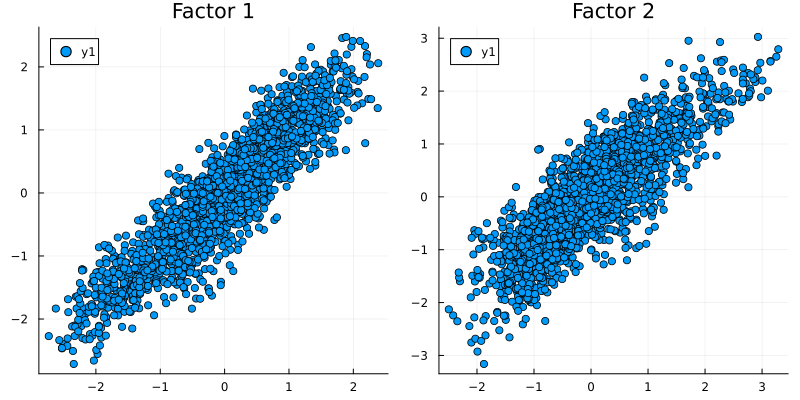

In [31]:
# scatter plots
using Plots
plot(
    scatter(F_mean_projected[:, 1], F_ord[:, 1], title="Factor 1"),
    scatter(F_mean_projected[:, 2], F_ord[:, 2], title="Factor 2"),
    layout = (1, 2),  # 1 row, 2 columns
    size = (800, 400)  # Total figure size
)

In [32]:
# save the results
using CSV, DataFrames
# Assuming 'matrix' is your N by K matrix
df_F_mean = DataFrame(F_mean_euclidean, :auto)
CSV.write("../results/PMCMC/F_mean_euclidean.csv", df_F_mean)  # Save DataFrame to CSV file

"../results/PMCMC/F_mean_euclidean.csv"

In [33]:
comparison_df = generate_comparison_table(F_mean_euclidean, F_mean_projected, F_ord);

┌────────────────────┬──────────┬──────────┐
│             Metric │ Factor 1 │ Factor 2 │
│             String │  Float64 │  Float64 │
├────────────────────┼──────────┼──────────┤
│ Euclidean Distance │  18.6992 │  24.6556 │
│         Sphere Var │  97.4897 │  276.127 │
└────────────────────┴──────────┴──────────┘


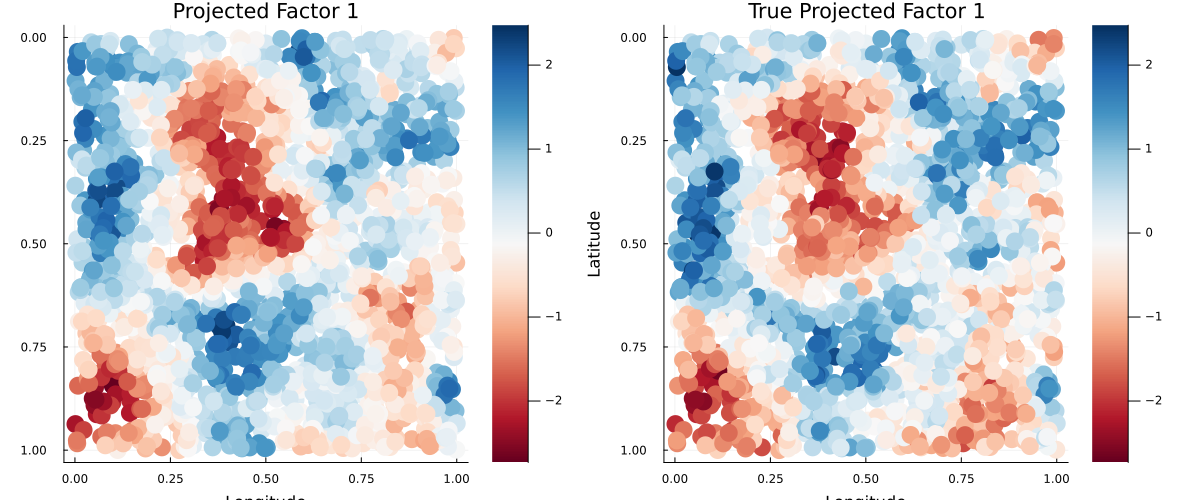

In [34]:
#using Plots

# Coordinates
lon = coords_ord[:, 1]
lat = coords_ord[:, 2]

# Calculate the combined range for color scaling
combined_values = vcat(F_mean_projected[:, 1], F_ord[:, 1])
color_limits = (minimum(combined_values), maximum(combined_values))

# Create subplot for both factors
plot(
    # Factor 1 plot
    scatter(
        lon, lat, 
        zcolor = F_mean_projected[:, 1], 
        color = :RdBu, 
        markerstrokewidth = 0, 
        legend = false,
        markersize = 10.0, 
        xlabel = "Longitude", 
        ylabel = "Latitude", 
        title = "Projected Factor 1",
        yflip = true,
        colorbar = true,
        clims = color_limits
    ),
    
    # Factor 2 plot
    scatter(
        lon, lat, 
        zcolor = F_ord[:, 1], 
        color = :RdBu, 
        markerstrokewidth = 0, 
        legend = false,
        markersize = 10.0, 
        xlabel = "Longitude", 
        ylabel = "Latitude", 
        title = "True Projected Factor 1",
        yflip = true,
        colorbar = true,
        clims = color_limits
    ),
    
    # Layout options
    layout = (1, 2),  # 1 row, 2 columns
    size = (1200, 500)  # Total figure size
)

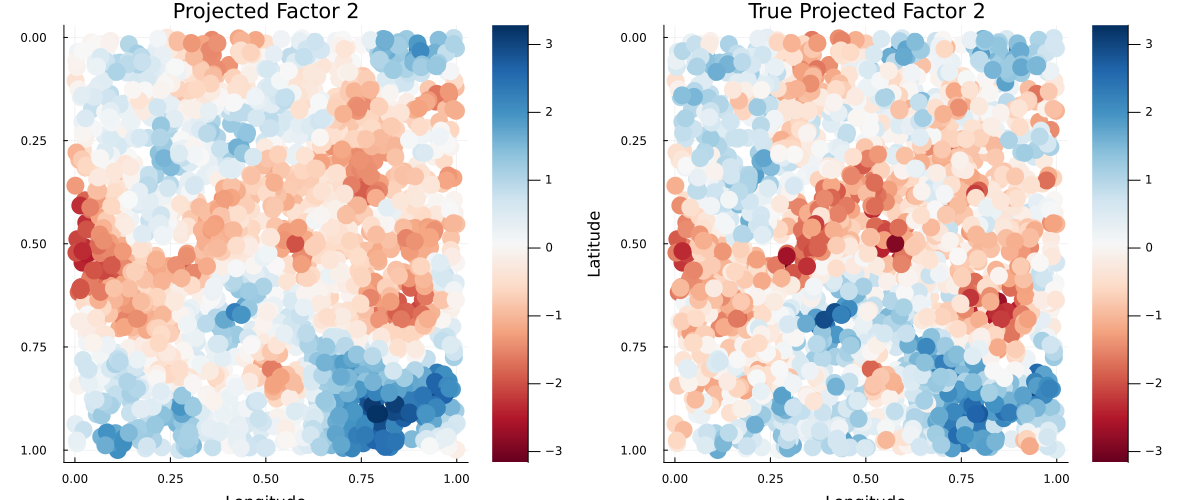

In [35]:
#using Plots

# Coordinates
lon = coords_ord[:, 1]
lat = coords_ord[:, 2]


# Calculate the combined range for color scaling
combined_values = vcat(F_mean_projected[:, 2], F_ord[:, 2])
color_limits = (minimum(combined_values), maximum(combined_values))

plot(
    # Factor 1 plot
    scatter(
        lon, lat, 
        zcolor = F_mean_projected[:, 2], 
        color = :RdBu, 
        markerstrokewidth = 0, 
        legend = false,
        markersize = 10.0, 
        xlabel = "Longitude", 
        ylabel = "Latitude", 
        title = "Projected Factor 2",
        yflip = true,
        colorbar = true,
        clims = color_limits  # Add common color limits
    ),
    
    # Factor 2 plot
    scatter(
        lon, lat, 
        zcolor = F_ord[:, 2], 
        color = :RdBu, 
        markerstrokewidth = 0, 
        legend = false,
        markersize = 10.0, 
        xlabel = "Longitude", 
        ylabel = "Latitude", 
        title = "True Projected Factor 2",
        yflip = true,
        colorbar = true,
        clims = color_limits  # Add common color limits
    ),
    
    # Layout options
    layout = (1, 2),  # 1 row, 2 columns
    size = (1200, 500)  # Total figure size
)

# Plots for paper  

In [36]:
# tract plots
β_chain = Chains(β_pos_sam[1:N_sam, 1:2:(q*p), :]);
Λ_chain = Chains(Λ_pos_sam[1:N_sam, :, :]);
# Plot only the trace plots
p1 = plot()
for i in 1:size(β_chain.value, 2)
    plot!(β_chain[:, i, :], label="", legend=false, size=(800, 500))
end
savefig(p1, "../results/PMCMC/PMCMC_intercept_trace.png")
    
# Plot only the trace plots
p2 = plot()
for i in 1:size(Λ_chain.value, 2)
    plot!(Λ_chain[:, i, :], label="", legend=false, size=(800, 500))
end
savefig(p2, "../results/PMCMC/PMCMC_Lambda_trace.png")

"/Users/tati/Documents/Github/PBSF_lit/sim/results/PMCMC/PMCMC_Lambda_trace.png"

In [37]:
# Coordinates
lon = coords_ord[:, 1]
lat = coords_ord[:, 2]

# Iterate through factors (assuming 2 factors)
for k in 1:2
    # Calculate the combined range for color scaling for this factor
    combined_values = vcat(F_mean_projected[:, k], F_ord[:, k])
    color_limits = (minimum(combined_values), maximum(combined_values))

    # Projected Factor Plot
    p1 = scatter(
        lon, lat, 
        zcolor = F_mean_projected[:, k], 
        color = :RdBu, 
        markerstrokewidth = 0, 
        legend = false,
        markersize = 10.0, 
        yflip = true,
        colorbar = false,
        clims = color_limits,
        size = (500, 500)
    )

    # Save projected factor plot
    Plots.savefig(p1, "../results/PMCMC/PMCMC_estimated_F$k.png")

    # True Factor Plot
    p2 = scatter(
        lon, lat, 
        zcolor = F_ord[:, k], 
        color = :RdBu, 
        markerstrokewidth = 0, 
        legend = false,
        markersize = 10.0, 
        yflip = true,
        colorbar = false,
        clims = color_limits,
        size = (500, 500)
    )

    # Save true factor plot
    Plots.savefig(p2, "../results/PMCMC/PMCMC_True_F$k.png")
end